# Torus links and neural networks

We propose to investigate how complex a neural network needs to be in order to accurately distinguish the components of increasingly tangled links in ambient three-dimensional space. More precisely, we use simulated data to measure the size and number of layers a neural network needs to have to successfully separate the components of torus links. If a reader needs a quick exposition about torus knots and links, the wikipedia page wikipedia.org/wiki/Torus_knot provides a fast account. Key facts are: 
- a torus link is a link in Euclidean $3$-space whose strands lie on the surface of the standardly embedded torus,
- the $(p, q)$-torus link has $n = gcd(p, q)$ components, each of which is a $(p', q')$-torus knot where $p' = p/n$, $q' = q/n$, 
- the $(p, q)$-torus knot for coprime $p, q$ winds around the torus $p$ times in the longitude direction and $q$ times around the meridian direction. 

At each step of our experiment, we shall fix integers $p$ and $q$ with $gcd(p, q) = n$ and train neural networks to tell apart the $n$ strands of the $(p, q)$-torus link. As $p$ and $q$ increase, the torus link of type $(p, q)$ becomes increasingly tangled, in the sense that its crossing number, linking number and many other invariants increase. The cases where $n = gcd(p, q)$ is low are of prime interest, since few strands are often enough to get very complicated links. 

## Generating the simulated data

We begin with Python functions generating points that lie on the $n$ strands of a $(p, q)$-torus link, $gcd(p, q) = n$. Thankfully, there are easy parameterizations for these embeddings. (This actually motivated the choice of torus links over other infinite families. In general, finding parameterizations or algebraic equations for a link is a notoriously hard problem.) If $p$ and $q$ are coprime, the one and only strand of the $(p, q)$-torus knot is parameterized by
$$
x(t) = (\cos(qt) + 2)\cos(pt), 
$$
$$
y(t) = (\cos(qt) + 2)\sin(pt), 
$$
$$
z(t) = -\sin(qt),
$$
where $t \in [0, 2\pi]$. When $n = gcd(p, q)$ is greater than one, we can use the parameterization above with $p' = p/n$ and $q' = q/n$ to get one component of the $(p, q)$-torus link. We then rely on the following fact: the other components are obtained by applying rotations of angles $2\pi k/qn$, $0 < k < n$ along the $z$-axis to the first component. The proof of this last assertion follows from further properties of torus knots and links. It can be derived from, e.g, the connection between torus links and the algebraic equations $w_1^p + w_2^q = 0$ in $\mathbb{C}^2$. From now on, we speak of the zeroth, first, ..., $(n-1)$-st component of a link, instead of the first, second, ... etc. to match Python's enumerating conventions. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import pyplot
%matplotlib widget 
#This last line requires the jupyter-matplotlib extension. pip install ipympl

In [2]:
def x(p, q, t, phase_shift):
    return (np.cos(q*t) + 2)*np.cos(p*t + phase_shift) #These two phase shifts will implement the rotations advertized above.

def y(p, q, t, phase_shift):
    return (np.cos(q*t) + 2)*np.sin(p*t + phase_shift) #These two phase shifts will implement the rotations advertized above.

def z(q, t):
    return -np.sin(q*t)

def torusLink(p, q, t, phase_shift):
    return [x(p, q, t, phase_shift), y(p, q, t, phase_shift), z(q, t)]

In [3]:
#Implements the generation strategy outlined above. 
def simulateData(p, q, N): 
    n = np.gcd(p, q)
    p_prime = int(p/n)
    q_prime = int(q/n)
    features = [torusLink(p_prime, q_prime, t, 0) for t in np.linspace(0, 2*np.pi, num = int(N/n), endpoint = False)]
    responses = np.zeros(int(N/n))
    for k in range(1, n):
        features = np.concatenate((features, [torusLink(p_prime, q_prime, t, 2*np.pi*k/(q_prime*n)) for t in np.linspace(0, 2*np.pi, num = int(N/n), endpoint = False)]))
        responses = np.concatenate((responses, k*np.ones(int(N/n))))
    return features, responses

We are ready to generate data: we do so and plot it. 

In [4]:
p, q = 18, 4
n = int(np.gcd(p, q))
N = 1000
N = n*int(N/n) #Replaces N with a close multiple of gcd(p, q) 
torusLinkFeatures, torusLinksResponses = simulateData(p, q, N)

In [5]:
#A function to plot at most twenty colored collections of points in three dimensions
def threeDimPlot(collections):
    colors = matplotlib.cm.tab10(range(10)) #Provides a collection of twenty colors
    ax = plt.figure().add_subplot(projection = '3d')
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    for (collection, color) in zip(collections, colors): 
        ax.scatter(collection[0], collection[1], collection[2], color = color)
    return ax

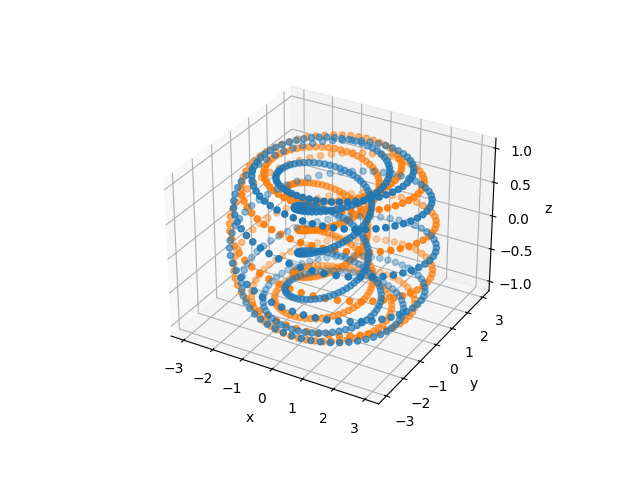

In [6]:
collections = []
for i in range(n): #We retrieve the points in "features" component by component
    x_ = [torusLinkFeatures[k][0] for k in range(i*int(N/n), (i+1)*int(N/n))]
    y_ = [torusLinkFeatures[k][1] for k in range(i*int(N/n), (i+1)*int(N/n))]
    z_ = [torusLinkFeatures[k][2] for k in range(i*int(N/n), (i+1)*int(N/n))]
    collections.append([x_, y_, z_])

ax = threeDimPlot(collections)
plt.show()

In [7]:
plt.close() #Frees the memory occupied by the figure. 

## Training neural networks

We use `torch` to train neural networks. The third cell import wrapper and helper functions from the `ISLP` package. These are not part of `torch`, but are provided by the authors of the ISLP book (https://www.statlearning.com/) to ease the syntax of certain `torch` code snippets in simple cases. 

In [8]:
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchinfo import summary
from pytorch_lightning.callbacks import EarlyStopping

In [9]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger

In [10]:
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)

### Arranging the data into a `DataModule`

We transform our data into `tensors`, the standard datatype accessible to `torch`. Note that `torch` typically works with 32-bit (= single precision) floating point numbers. We therefore convert the $x$, $y$ and $z$ coordinates of our data to `np.float32` before forming the tensor. On the other hand, the reponse --the index of the component a point lies in-- is an integer, which we are required to convert into a 64-bit integer (to use `torch`´s cross-entropy loss function). The features and responses tensors are then arranged into a `Dataset` using `TensorDataset()`. Because the general training setup in `pytorch_lightning` involves training, validation and test data, we carry this task out three times. Our data is simulated, so this is virtually free. 

In [11]:
p, q = 9, 3
n = int(np.gcd(p, q))
N = 10000
N = n*int(N/n) #Replaces N with a close multiple of gcd(p, q) 
M = n*int(N/(10*n)) #A smaller size for validation and test

features_tmp, responses_tmp = simulateData(p, q, N)
torusLinkFeatures_train_t = torch.tensor(features_tmp.astype(np.float32))
torusLinkResponses_train_t = torch.tensor(responses_tmp.astype(np.int64))
torusLinkData_train = TensorDataset(torusLinkFeatures_train_t, torusLinkResponses_train_t)

features_tmp, responses_tmp = simulateData(p, q, M)
torusLinkFeatures_val_t = torch.tensor(features_tmp.astype(np.float32))
torusLinkResponses_val_t = torch.tensor(responses_tmp.astype(np.int64))
torusLinkData_val = TensorDataset(torusLinkFeatures_val_t, torusLinkResponses_val_t)

features_tmp, responses_tmp = simulateData(p, q, M)
torusLinkFeatures_test_t = torch.tensor(features_tmp.astype(np.float32))
torusLinkResponses_test_t = torch.tensor(responses_tmp.astype(np.int64))
torusLinkData_test = TensorDataset(torusLinkFeatures_test_t, torusLinkResponses_test_t)

Each dataset is passed to a `DataLoader()`, which ultimately passes data into the network. The helper function `SimpleDataModule()` from `ISLP` makes this easy. One of its arguments is `num_workers`, which indicates how many processes will be used for the loading of the data. The `torch` package will inspect the process running and determine a maximum number of workers. (This depends on the computing hardware and the number of cores available.) The `ISLP` package contains the function `rec_num_workers()` to compute this. 

In [12]:
max_num_workers = rec_num_workers()
max_num_workers

8

In [13]:
torusLink_dm = SimpleDataModule(torusLinkData_train,
                                  torusLinkData_test,
                                  batch_size = 32,
                                  num_workers = max_num_workers,
                                  validation = torusLinkData_val)

### Specifying the network

We move on to the neural network itself. We define a sub-class `TorusLinkModel` of `torch`'s generic `nn.Module` and specify the architecture of the neural network we want to use. In our situation it is fairly straitghtforward, consisting of linear and ReLU activation layers only. The `layer_sizes` array in the `__init__` method summaries the whole shape of the network: its size indicates the desired number of hidden combined linear-ReLU layers, and the $i$-th value indicates the size of the $i$-th layer. 

In [104]:
class BuildingBlock(nn.Module):
    
    def __init__(self, in_size, out_size): 
        super(BuildingBlock, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.ReLU(),
            nn.Linear(in_size, out_size))

    def forward(self, x):
        x = self.flatten(x)
        return self.sequential(x)

In [109]:
class TorusLinkModel(nn.Module):
    
    def __init__(self, layer_sizes, input_size, output_size): 
        super(TorusLinkModel, self).__init__()
        self.flatten = nn.Flatten()
        self.first_maps = nn.Sequential(nn.Linear(input_size, layer_sizes[0]))
        if len(layer_sizes) > 1:
            self.middle_maps = nn.Sequential(*[BuildingBlock(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes) - 1)])
        else:
            self.middle_maps = nn.Sequential()
        self.last_maps = nn.Sequential(nn.ReLU(), nn.Linear(layer_sizes[-1], output_size))
        #self.last_maps = nn.Sequential(nn.ReLU(), nn.Linear(layer_sizes[-1], 1))

    def forward(self, x):
        x = self.first_maps(x)
        x = self.middle_maps(x)
        x = self.last_maps(x)
        return x

The package `torchinfo` provides a `summary()` function that neatly displays the architecture. We specify the size of the input and see the size of each tensor as it passes through the layers of the network. 

In [106]:
layer_sizes = [10, 10, 10, 10]
torusLink_model = TorusLinkModel(layer_sizes, 3, n)

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)
 * (tuple of ints size, *, torch.memory_format memory_format = None, Tensor out = None, torch.dtype dtype = None, torch.layout layout = None, torch.device device = None, bool pin_memory = False, bool requires_grad = False)


In [98]:
summary(torusLink_model, 
        input_size = [N, 3],
        col_names = ['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
TorusLinkModel                           [9999, 3]                 [9999, 3]                 --
├─Sequential: 1-1                        [9999, 3]                 [9999, 10]                --
│    └─Linear: 2-1                       [9999, 3]                 [9999, 10]                40
├─Sequential: 1-2                        [9999, 10]                [9999, 10]                --
│    └─BuildingBlock: 2-2                [9999, 10]                [9999, 10]                --
│    │    └─Flatten: 3-1                 [9999, 10]                [9999, 10]                --
│    │    └─Sequential: 3-2              [9999, 10]                [9999, 10]                110
│    └─BuildingBlock: 2-3                [9999, 10]                [9999, 10]                --
│    │    └─Flatten: 3-3                 [9999, 10]                [9999, 10]                --
│    │    └─Sequential: 3-4       

We summon an instance of TorusLinkModel and build a `Module` with it. We again use a helper function from `ISLP`: `SimpleModule()`. By using the `SimpleModule.classification()` method,  we indicate that we will the cross-entropy loss function. We supply it with the number of classes in the problem. If we were to specify a non-default learning rate (the default one is $0.01$), or other specific instructions for the upcoming stochastic gradient descent, this would be the place to do it (using a `torch optimizer`). 

In [99]:
torusLink_module = SimpleModule.classification(torusLink_model, num_classes = n)
#torusLink_module = SimpleModule.binary_classification(torusLink_model)

### Setting a logger

We log our results via `CSVLogger()`, which stores the results in a CSV file within a directory `logs/torusLink`. After the fitting is complete, this allows us to easily load the results as a `pd.DataFrame()` and visualize them. 

In [20]:
torusLink_logger = CSVLogger('logs', name = 'torusLink')

### Training the model

Finally we are ready to train our model and log the results. We use the `Trainer()` object from `pytorch_lightning` to do this work. The argument `datamodule = torusLink_dm` tells the trainer how training/validation/test logs are produced, while the first argument `torusLink_module` specifies the network architecture as well as the training/validation/test steps. The `callbacks` argument allows for several tasks to be carried out at various points while training a model. The `ErrorTracker()` callback will enable the computation of the validation accuracy while training and, finally, of test accuracy. Our goal is to measure the how complex neural networks need to be in order to succeed at certain tasks. In particular, we are not interested in the trained models themselves, and do not want to train our networks more than needed. Thus we include an `EarlyStopping` callback to our `Trainer` that interrupts training if at some point during the fitting, the validation accuracy has not been improving by at least $1\%$ for the last five training steps. 

In [21]:
torusLink_trainer = Trainer(deterministic = False,
                      max_epochs = 30,
                      log_every_n_steps = 5,
                      logger = torusLink_logger,
                      callbacks = [ErrorTracker(), EarlyStopping(monitor = 'valid_accuracy', patience = 5, mode = 'max', min_delta = 0.01)])
torusLink_trainer.fit(torusLink_module, datamodule = torusLink_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 403    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
403       Trainable params
0         Non-trainable params
403       Total params
0.002     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

At each step of stochastic gradient descent, the algorithm randomly selects 32 training observations for the computation of the gradient. An epoch amounts to the number of stochastic gradient descent steps required to process $N$ observations. The training set has $N = 10000$, and we specified a `batch_size` of $32$ in the construction of  `torusLink_dm`, an epoch is thus $10000/32 = 312.5$ stochastic gradient descent steps. 

### Testing the model

In [22]:
torusLink_trainer.test(torusLink_module, datamodule = torusLink_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |                                                                          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9859859943389893
        test_loss           0.05126672610640526
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.05126672610640526, 'test_accuracy': 0.9859859943389893}]

The results of the fit have been logged into a CSV file. We can find the results specific to this run in the `experiment.metrics_file_path`
attribute of the logger. (Each time the model is fit, the logger outputs results into a new subdirectory of `logs/hitters`.) We plot the accuracy as a function of the number of epochs. 

In [23]:
def summary_plot(results, ax, col, y_label, valid_legend = 'Validation', training_legend = 'Training'):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch', f'valid_{col}'],
                       ['black', 'red'],
                       [training_legend, valid_legend]):
        results.plot(x = 'epoch',
                     y = column,
                     label = label,
                     marker = 'o',
                     color = color,
                     ax = ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(y_label)
    return ax

<Axes: xlabel='Epoch', ylabel='Accuracy'>

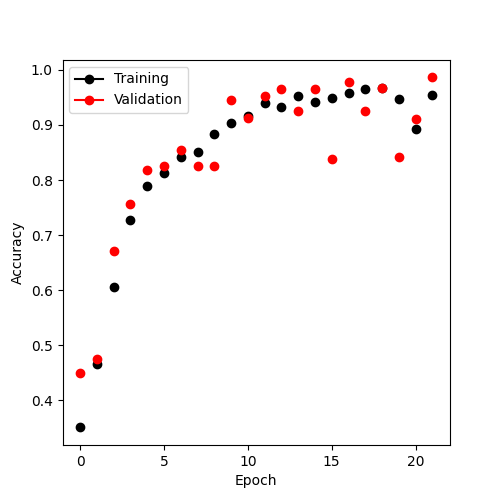

In [24]:
torusLink_results = pd.read_csv(torusLink_logger.experiment.metrics_file_path)
fig, ax = pyplot.subplots(1, 1, figsize=(5, 5))
summary_plot(torusLink_results, ax, 'accuracy', 'Accuracy')

### Cleanup 

In [100]:
del(torusLink_model, torusLink_dm, torusLink_module,
    torusLink_logger,torusLink_trainer,
    features_tmp, responses_tmp)
plt.close()

NameError: name 'torusLink_dm' is not defined

## Network complexity

We want to use the number of parameters in a neural network as a measure of its complexity. We restrict ourselves to the networks in which all the layers have the same size. We typically write $s$ for this size, and $l$ for the number of layers. The number of parameters in a neural network with $l$ layers, each of size $s$ is 
$$
p(l, s) = (l-1)s^2 + (l+n-3)s + n.
$$
(This holds in our special case of imput dimension $3$ and $n$ output layers.) In more generality, for a neural network whose hidden layers have sizes recorded in an array `layer_sizes`, the total number of parameters can be recovered using the function below. 

In [19]:
def num_parameters(layer_sizes, input_size, output_size):
    num_param = (input_size + 1)*layer_sizes[0]
    for i in range(len(layer_sizes) - 1):
        num_param += (layer_sizes[i] + 1)*layer_sizes[i + 1]
    num_param += (layer_sizes[-1] + 1)*output_size
    return num_param
num_parameters(layer_sizes, 3, n)

403

We write a function that provides the pairs $(l, s)$ for which the networks with $l$ layers, all of size $s$ have a target number $P$ of parameters, i.e, the $(l, s)$ for which $p(l, s) = P$. 

In [120]:
def possibleLayerLayouts(P, n):
    if P <= n: 
        return []
    possible_pairs = []
    s_max = max(n + 1, (2 - n + np.sqrt((n-2)**2 + 4*(P-n)))/2)
    for s in range(n, int(s_max) + 1):
        l = (P - n - (n+4)*s)/(s + s**2) + 1
        if l.is_integer(): 
            if l > 0:
                possible_pairs.append([int(l), s])
    return possible_pairs

In [153]:
P = 38
n = 3
possibleLayerLayouts(P, n), [num_parameters(layer_layout[1]*np.ones(layer_layout[0]), 3, n) for layer_layout in possibleLayerLayouts(P, n)]

([[1, 5]], [38.0])

Because we shall use these values many times in what follows, we generate an array whose $P$-th entry is an array consisting of all the pairs $(l, s)$ for which $p(l, s)$ equals $P$. This avoids recomputing the same numbers many times over. 

In [122]:
def architectures(P_max, n):
    architectures = []
    for P in range(1, P_max + 1):
        architectures.append(possibleLayerLayouts(P, n))
    return architectures

## The experiment

### First steps

The setup is complete. We measure the number of parameters a neural network needs to have to separate --with an accuracy of at $95\%$-- the three strands of a $(3p, 3)$-torus link for $p > 0$. Using the function above, we iterate over the possible network architectures, ordered by number of parameters. 

In [ ]:
def min_parameters(p, q, all_architectures): 
    n = int(np.gcd(p, q))
    
    N = 10000
    N = n*int(N/n) #Replaces N with a close multiple of gcd(p, q) 
    M = n*int(N/(10*n)) #A smaller size for validation and test
    
    max_num_workers = rec_num_workers()
    
    for P, possible_layer_layouts in enumerate(all_architectures): 
        print("Trying networks with", P + 1, "parameters")
        for layer_layout in possible_layer_layouts: 
            layer_sizes = (layer_layout[1]*np.ones(layer_layout[0])).astype(int)
            print("Trying a network with architecture", layer_sizes)
            features_tmp, responses_tmp = simulateData(p, q, N)
            torusLinkFeatures_train_t = torch.tensor(features_tmp.astype(np.float32))
            torusLinkResponses_train_t = torch.tensor(responses_tmp.astype(np.int64))
            torusLinkData_train = TensorDataset(torusLinkFeatures_train_t, torusLinkResponses_train_t)
            
            features_tmp, responses_tmp = simulateData(p, q, M)
            torusLinkFeatures_val_t = torch.tensor(features_tmp.astype(np.float32))
            torusLinkResponses_val_t = torch.tensor(responses_tmp.astype(np.int64))
            torusLinkData_val = TensorDataset(torusLinkFeatures_val_t, torusLinkResponses_val_t)
            
            features_tmp, responses_tmp = simulateData(p, q, M)
            torusLinkFeatures_test_t = torch.tensor(features_tmp.astype(np.float32))
            torusLinkResponses_test_t = torch.tensor(responses_tmp.astype(np.int64))
            torusLinkData_test = TensorDataset(torusLinkFeatures_test_t, torusLinkResponses_test_t)

            torusLink_dm = SimpleDataModule(torusLinkData_train,
                                  torusLinkData_test,
                                  batch_size = 32,
                                  num_workers = max_num_workers,
                                  validation = torusLinkData_val)

            torusLink_model = TorusLinkModel(layer_sizes, 3, n)
            torusLink_module = SimpleModule.classification(torusLink_model, num_classes = n)

            torusLink_logger = CSVLogger('logs', name = 'torusLink')

            torusLink_trainer = Trainer(deterministic = False,
                              max_epochs = 30,
                              log_every_n_steps = 5,
                              logger = torusLink_logger,
                              callbacks = [ErrorTracker(), EarlyStopping(monitor = 'valid_accuracy', patience = 5, mode = 'max', min_delta = 0.01, verbose = True)])
            torusLink_trainer.fit(torusLink_module, datamodule = torusLink_dm)
            
            torusLink_results = pd.read_csv(torusLink_logger.experiment.metrics_file_path)
            accuracy = torusLink_results['valid_accuracy'].dropna().iloc[-1] 

            
            print(accuracy)
            
            if accuracy > 0.95: 
                return P + 1
    return -1

In [155]:
measured_min_parameters = []
all_architectures = architectures(1000, 3)
for p in range(1, 5):
    print("Trying to separate the three strands of a (" + str(3*p) + ", " + str(p) + ")-torus link")
    measured_min_parameters.append(min_parameters(3*p, 3, all_architectures))
measured_min_parameters

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 24     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Trying to separate the three strands of a (3, 1)-torus link
Trying networks with 1 parameters
Trying networks with 2 parameters
Trying networks with 3 parameters
Trying networks with 4 parameters
Trying networks with 5 parameters
Trying networks with 6 parameters
Trying networks with 7 parameters
Trying networks with 8 parameters
Trying networks with 9 parameters
Trying networks with 10 parameters
Trying networks with 11 parameters
Trying networks with 12 parameters
Trying networks with 13 parameters
Trying networks with 14 parameters
Trying networks with 15 parameters
Trying networks with 16 parameters
Trying networks with 17 parameters
Trying networks with 18 parameters
Trying networks with 19 parameters
Trying networks with 20 parameters
Trying networks with 21 parameters
Trying networks with 22 parameters
Trying networks with 23 parameters
Trying networks with 24 parameters
Trying a network with architecture [3]


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.667


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.025 >= min_delta = 0.01. New best score: 0.692


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.707


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.707. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 31     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
31        Trainable params
0         Non-trainable params
31        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


0.7027027010917664
Trying networks with 25 parameters
Trying networks with 26 parameters
Trying networks with 27 parameters
Trying networks with 28 parameters
Trying networks with 29 parameters
Trying networks with 30 parameters
Trying networks with 31 parameters
Trying a network with architecture [4]


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.863


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

After computing the first values of `measured_min_parameters`, we confirm two predictable facts: 
- the function that maps $p$ to the minimum number of parameters a neural network needs to have to successfully separate the strands of a $(np, p)$-torus links is (very) increasing,
- the neural networks with $l$ layers, all of size $s$ with $l>s$ tend to perform very poorly for this task.

Thus we can modify the code in the cells above for the computation of the subsequent values:
- when trying to separate the strands of a certain link, we do not have to give the architectures that failed separating the strands of a less tangled link a try,
- we do not have to give the architectures with $l>s$ a try.
  
This could slightly speed up the process. We edit the code accordingly with new functions `admissibleLayerLayouts`, `admissibleArchitectures` below. 

In [195]:
def admissibleLayerLayouts(P, n):
    if P <= n: 
        return []
    possible_pairs = []
    s_max = max(n + 1, (2 - n + np.sqrt((n-2)**2 + 4*(P-n)))/2)
    for s in range(n, int(s_max) + 1):
        l = (P - n - (n+4)*s)/(s + s**2) + 1
        if l.is_integer(): 
            if l > 0 and s > l:
                possible_pairs.append([int(l), s])
    return possible_pairs

In [196]:
def admissibleArchitectures(P_max, n):
    architectures = []
    for P in range(1, P_max + 1):
        architectures.append(admissibleLayerLayouts(P, n))
    return architectures

In [204]:
def new_min_parameters(p, q, admissible_architectures): 
    n = int(np.gcd(p, q))
    
    N = 10000
    N = n*int(N/n) #Replaces N with a close multiple of gcd(p, q) 
    M = n*int(N/(10*n)) #A smaller size for validation and test
    
    max_num_workers = rec_num_workers()

    i = 0
    
    while i < len(admissible_architectures): 
        for layer_layout in admissible_architectures[i]: 
            layer_sizes = (layer_layout[1]*np.ones(layer_layout[0])).astype(int)
            num_param = num_parameters(layer_sizes, 3, n)
            print("Trying a network with architecture", layer_sizes, "--", num_param, "parameters")
            features_tmp, responses_tmp = simulateData(p, q, N)
            torusLinkFeatures_train_t = torch.tensor(features_tmp.astype(np.float32))
            torusLinkResponses_train_t = torch.tensor(responses_tmp.astype(np.int64))
            torusLinkData_train = TensorDataset(torusLinkFeatures_train_t, torusLinkResponses_train_t)
            
            features_tmp, responses_tmp = simulateData(p, q, M)
            torusLinkFeatures_val_t = torch.tensor(features_tmp.astype(np.float32))
            torusLinkResponses_val_t = torch.tensor(responses_tmp.astype(np.int64))
            torusLinkData_val = TensorDataset(torusLinkFeatures_val_t, torusLinkResponses_val_t)
            
            features_tmp, responses_tmp = simulateData(p, q, M)
            torusLinkFeatures_test_t = torch.tensor(features_tmp.astype(np.float32))
            torusLinkResponses_test_t = torch.tensor(responses_tmp.astype(np.int64))
            torusLinkData_test = TensorDataset(torusLinkFeatures_test_t, torusLinkResponses_test_t)

            torusLink_dm = SimpleDataModule(torusLinkData_train,
                                  torusLinkData_test,
                                  batch_size = 32,
                                  num_workers = max_num_workers,
                                  validation = torusLinkData_val)

            torusLink_model = TorusLinkModel(layer_sizes, 3, n)
            torusLink_module = SimpleModule.classification(torusLink_model, num_classes = n)

            torusLink_logger = CSVLogger('logs', name = 'torusLink')

            torusLink_trainer = Trainer(deterministic = False,
                              max_epochs = 50,
                              log_every_n_steps = 5,
                              logger = torusLink_logger,
                              callbacks = [ErrorTracker(), EarlyStopping(monitor = 'valid_accuracy', patience = 3, mode = 'max', min_delta = 0.01, verbose = True)])
            torusLink_trainer.fit(torusLink_module, datamodule = torusLink_dm)
            
            torusLink_results = pd.read_csv(torusLink_logger.experiment.metrics_file_path)
            accuracy = torusLink_results['valid_accuracy'].dropna().iloc[-1] 

            
            print(accuracy)
            
            if accuracy > 0.95: 
                return num_param
        admissible_architectures.pop(0)
    return -1

In [198]:
measured_min_parameters = []
admissible_architectures = admissibleArchitectures(1000, n)
for p in range(1, 5):
    print("Trying to separate the three strands of a (" + str(3*p) + ", " + str(p) + ")-torus link")
    measured_min_parameters.append(new_min_parameters(3*p, 3, admissible_architectures))
measured_min_parameters # [38, 108, 183, 399]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 24     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
24        Trainable params
0         Non-trainable params
24        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Trying to separate the three strands of a (3, 1)-torus link
Trying a network with architecture [3] -- 24 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.563


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.024 >= min_delta = 0.01. New best score: 0.587


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.587. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 31     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
31        Trainable params
0         Non-trainable params
31        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


0.5905905961990356
Trying a network with architecture [4] -- 31 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.858


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.020 >= min_delta = 0.01. New best score: 0.878


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.010 >= min_delta = 0.01. New best score: 0.888


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.902


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.902. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 36     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
36        Trainable params
0         Non-trainable params
36        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.9069069027900696
Trying a network with architecture [3 3] -- 36 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.748


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.01. New best score: 0.775


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.775. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 38     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


0.7537537813186646
Trying a network with architecture [5] -- 38 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.888


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.01. New best score: 0.932


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.971


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.010 >= min_delta = 0.01. New best score: 0.981


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.981. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 38     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
38        Trainable params
0         Non-trainable params
38        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


0.988988995552063
Trying to separate the three strands of a (6, 2)-torus link
Trying a network with architecture [5] -- 38 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.511


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.117 >= min_delta = 0.01. New best score: 0.628


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.667


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.679


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.679. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 45     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
45        Trainable params
0         Non-trainable params
45        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


0.6756756901741028
Trying a network with architecture [6] -- 45 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.497


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.042 >= min_delta = 0.01. New best score: 0.540


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.01. New best score: 0.577


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.616


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.632


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.665


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.665. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 51     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.673673689365387
Trying a network with architecture [4 4] -- 51 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.577


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.038 >= min_delta = 0.01. New best score: 0.615


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.063 >= min_delta = 0.01. New best score: 0.678


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.690


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.690. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 68     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
68        Trainable params
0         Non-trainable params
68        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.6986986994743347
Trying a network with architecture [5 5] -- 68 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.654


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.089 >= min_delta = 0.01. New best score: 0.743


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.762


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.01. New best score: 0.792


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.811


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.811. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 71     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
71        Trainable params
0         Non-trainable params
71        Total params
0.000     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.7957957983016968
Trying a network with architecture [4 4 4] -- 71 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.392


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.404


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.419


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.419. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 87     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
87        Trainable params
0         Non-trainable params
87        Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.4104104042053222
Trying a network with architecture [6 6] -- 87 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.728


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.135 >= min_delta = 0.01. New best score: 0.863


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.879


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.029 >= min_delta = 0.01. New best score: 0.908


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.925


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.925. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 98     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
98        Trainable params
0         Non-trainable params
98        Total params
0.000     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.9169169068336488
Trying a network with architecture [5 5 5] -- 98 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.333


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.333. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 108    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
108       Trainable params
0         Non-trainable params
108       Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.3333333432674408
Trying a network with architecture [7 7] -- 108 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.868


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.066 >= min_delta = 0.01. New best score: 0.934


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.034 >= min_delta = 0.01. New best score: 0.968


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.983


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.983. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 108    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
108       Trainable params
0         Non-trainable params
108       Total params
0.000     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.9649649858474731
Trying to separate the three strands of a (9, 3)-torus link
Trying a network with architecture [7 7] -- 108 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.591


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.060 >= min_delta = 0.01. New best score: 0.651


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.074 >= min_delta = 0.01. New best score: 0.725


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.036 >= min_delta = 0.01. New best score: 0.761


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.779


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.062 >= min_delta = 0.01. New best score: 0.841


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.053 >= min_delta = 0.01. New best score: 0.894


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.913


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.931


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.931. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 128    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
128       Trainable params
0         Non-trainable params
128       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.9319319128990172
Trying a network with architecture [5 5 5 5] -- 128 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.442


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.060 >= min_delta = 0.01. New best score: 0.503


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.058 >= min_delta = 0.01. New best score: 0.561


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.01. New best score: 0.584


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.025 >= min_delta = 0.01. New best score: 0.609


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.609. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 129    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
129       Trainable params
0         Non-trainable params
129       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.5965965986251831
Trying a network with architecture [6 6 6] -- 129 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.370


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.076 >= min_delta = 0.01. New best score: 0.446


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.479


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.155 >= min_delta = 0.01. New best score: 0.635


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.038 >= min_delta = 0.01. New best score: 0.673


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.673. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 131    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
131       Trainable params
0         Non-trainable params
131       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.6356356143951416
Trying a network with architecture [8 8] -- 131 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.429


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.117 >= min_delta = 0.01. New best score: 0.547


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.098 >= min_delta = 0.01. New best score: 0.645


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.058 >= min_delta = 0.01. New best score: 0.703


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.021 >= min_delta = 0.01. New best score: 0.724


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.738


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.738. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 156    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
156       Trainable params
0         Non-trainable params
156       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.7457457184791565
Trying a network with architecture [9 9] -- 156 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.490


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.089 >= min_delta = 0.01. New best score: 0.580


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.174 >= min_delta = 0.01. New best score: 0.754


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.050 >= min_delta = 0.01. New best score: 0.804


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.054 >= min_delta = 0.01. New best score: 0.858


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.870


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.888


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.905


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.917


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.029 >= min_delta = 0.01. New best score: 0.946


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.946. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 164    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
164       Trainable params
0         Non-trainable params
164       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.9379379153251648
Trying a network with architecture [7 7 7] -- 164 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.478


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.076 >= min_delta = 0.01. New best score: 0.555


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.145 >= min_delta = 0.01. New best score: 0.700


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.032 >= min_delta = 0.01. New best score: 0.732


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.750


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.766


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.766. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 171    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
171       Trainable params
0         Non-trainable params
171       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.7637637853622437
Trying a network with architecture [6 6 6 6] -- 171 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.458


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.056 >= min_delta = 0.01. New best score: 0.515


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.094 >= min_delta = 0.01. New best score: 0.609


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.055 >= min_delta = 0.01. New best score: 0.664


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.034 >= min_delta = 0.01. New best score: 0.698


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.040 >= min_delta = 0.01. New best score: 0.738


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.064 >= min_delta = 0.01. New best score: 0.802


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.818


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.818. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 183    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
183       Trainable params
0         Non-trainable params
183       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.706706702709198
Trying a network with architecture [10 10] -- 183 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.584


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.149 >= min_delta = 0.01. New best score: 0.733


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.174 >= min_delta = 0.01. New best score: 0.907


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.038 >= min_delta = 0.01. New best score: 0.945


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.964


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.022 >= min_delta = 0.01. New best score: 0.986


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.998


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.998. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 183    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
183       Trainable params
0         Non-trainable params
183       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


1.0
Trying to separate the three strands of a (12, 4)-torus link
Trying a network with architecture [10 10] -- 183 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.360


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.156 >= min_delta = 0.01. New best score: 0.517


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.066 >= min_delta = 0.01. New best score: 0.583


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.014 >= min_delta = 0.01. New best score: 0.597


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.029 >= min_delta = 0.01. New best score: 0.626


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.093 >= min_delta = 0.01. New best score: 0.719


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.010 >= min_delta = 0.01. New best score: 0.729


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.742


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.753


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.772


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.772. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 203    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
203       Trainable params
0         Non-trainable params
203       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.7657657861709595
Trying a network with architecture [8 8 8] -- 203 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.463


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.126 >= min_delta = 0.01. New best score: 0.590


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.036 >= min_delta = 0.01. New best score: 0.626


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.029 >= min_delta = 0.01. New best score: 0.655


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.01. New best score: 0.685


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.700


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.053 >= min_delta = 0.01. New best score: 0.753


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.020 >= min_delta = 0.01. New best score: 0.773


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.01. New best score: 0.799


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.814


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.814. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 212    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
212       Trainable params
0         Non-trainable params
212       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.7677677869796753
Trying a network with architecture [11 11] -- 212 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.390


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.141 >= min_delta = 0.01. New best score: 0.532


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.545


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.021 >= min_delta = 0.01. New best score: 0.566


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.089 >= min_delta = 0.01. New best score: 0.655


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.031 >= min_delta = 0.01. New best score: 0.686


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.049 >= min_delta = 0.01. New best score: 0.735


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.754


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.040 >= min_delta = 0.01. New best score: 0.794


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.813


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.813. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 213    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
213       Trainable params
0         Non-trainable params
213       Total params
0.001     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.8058058023452759
Trying a network with architecture [6 6 6 6 6] -- 213 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.333


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.333. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 220    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
220       Trainable params
0         Non-trainable params
220       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.3333333432674408
Trying a network with architecture [7 7 7 7] -- 220 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.333


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.333. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 243    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
243       Trainable params
0         Non-trainable params
243       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.3333333432674408
Trying a network with architecture [12 12] -- 243 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.372


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.171 >= min_delta = 0.01. New best score: 0.544


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.045 >= min_delta = 0.01. New best score: 0.589


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.094 >= min_delta = 0.01. New best score: 0.683


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.01. New best score: 0.734


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.751


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.053 >= min_delta = 0.01. New best score: 0.804


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.819


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.021 >= min_delta = 0.01. New best score: 0.840


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.01. New best score: 0.877


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.025 >= min_delta = 0.01. New best score: 0.902


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.918


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.918. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 246    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
246       Trainable params
0         Non-trainable params
246       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.8758758902549744
Trying a network with architecture [9 9 9] -- 246 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.333


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.350


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.060 >= min_delta = 0.01. New best score: 0.410


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.155 >= min_delta = 0.01. New best score: 0.566


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.01. New best score: 0.617


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.636


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.085 >= min_delta = 0.01. New best score: 0.721


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.041 >= min_delta = 0.01. New best score: 0.762


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.010 >= min_delta = 0.01. New best score: 0.772


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.789


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.01. New best score: 0.833


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.010 >= min_delta = 0.01. New best score: 0.843


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.862


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.862. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 275    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
275       Trainable params
0         Non-trainable params
275       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.8128128051757812
Trying a network with architecture [8 8 8 8] -- 275 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.333


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.076 >= min_delta = 0.01. New best score: 0.409


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.086 >= min_delta = 0.01. New best score: 0.495


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.042 >= min_delta = 0.01. New best score: 0.538


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.066 >= min_delta = 0.01. New best score: 0.604


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.643


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.656


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.671


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.031 >= min_delta = 0.01. New best score: 0.702


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.713


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.01. New best score: 0.736


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.051 >= min_delta = 0.01. New best score: 0.787


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.805


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.01. New best score: 0.831


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.831. Signaling Trainer to stop.
`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 276    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
276       Trainable params
0         Non-trainable params
276       Total params
0.001     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.8288288116455078
Trying a network with architecture [7 7 7 7 7] -- 276 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.333


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.333. Signaling Trainer to stop.


0.3333333432674408
Trying a network with architecture [13 13] -- 276 parameters


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 276    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
276       Trainable params
0         Non-trainable params
276       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.480


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.105 >= min_delta = 0.01. New best score: 0.586


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.041 >= min_delta = 0.01. New best score: 0.627


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.039 >= min_delta = 0.01. New best score: 0.666


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.038 >= min_delta = 0.01. New best score: 0.704


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.737


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.756


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.066 >= min_delta = 0.01. New best score: 0.822


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.046 >= min_delta = 0.01. New best score: 0.868


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.881


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.881. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 293    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
293       Trainable params
0         Non-trainable params
293       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.8748748898506165
Trying a network with architecture [10 10 10] -- 293 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.333


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.333. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 311    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
311       Trainable params
0         Non-trainable params
311       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.3333333432674408
Trying a network with architecture [14 14] -- 311 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.414


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.118 >= min_delta = 0.01. New best score: 0.533


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.097 >= min_delta = 0.01. New best score: 0.630


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.050 >= min_delta = 0.01. New best score: 0.680


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.044 >= min_delta = 0.01. New best score: 0.724


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.757


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.020 >= min_delta = 0.01. New best score: 0.777


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.030 >= min_delta = 0.01. New best score: 0.807


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.01. New best score: 0.834


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.851


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.851. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 332    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
332       Trainable params
0         Non-trainable params
332       Total params
0.001     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


0.8148148059844971
Trying a network with architecture [7 7 7 7 7 7] -- 332 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.333


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.333. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 336    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
336       Trainable params
0         Non-trainable params
336       Total params
0.001     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


0.3333333432674408
Trying a network with architecture [9 9 9 9] -- 336 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.333


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.333. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 344    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
344       Trainable params
0         Non-trainable params
344       Total params
0.001     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.3333333432674408
Trying a network with architecture [11 11 11] -- 344 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.335


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.070 >= min_delta = 0.01. New best score: 0.405


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.152 >= min_delta = 0.01. New best score: 0.558


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.036 >= min_delta = 0.01. New best score: 0.594


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.090 >= min_delta = 0.01. New best score: 0.684


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.061 >= min_delta = 0.01. New best score: 0.745


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.043 >= min_delta = 0.01. New best score: 0.788


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.800


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.012 >= min_delta = 0.01. New best score: 0.812


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.845


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.845. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 347    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
347       Trainable params
0         Non-trainable params
347       Total params
0.001     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


0.8418418169021606
Trying a network with architecture [8 8 8 8 8] -- 347 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.333


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.333. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 348    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
348       Trainable params
0         Non-trainable params
348       Total params
0.001     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.3333333432674408
Trying a network with architecture [15 15] -- 348 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.390


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.101 >= min_delta = 0.01. New best score: 0.491


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.080 >= min_delta = 0.01. New best score: 0.572


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.054 >= min_delta = 0.01. New best score: 0.626


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.073 >= min_delta = 0.01. New best score: 0.699


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.022 >= min_delta = 0.01. New best score: 0.721


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.033 >= min_delta = 0.01. New best score: 0.754


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.028 >= min_delta = 0.01. New best score: 0.782


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.054 >= min_delta = 0.01. New best score: 0.836


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.040 >= min_delta = 0.01. New best score: 0.876


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.017 >= min_delta = 0.01. New best score: 0.893


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.023 >= min_delta = 0.01. New best score: 0.916


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.011 >= min_delta = 0.01. New best score: 0.927


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.013 >= min_delta = 0.01. New best score: 0.940


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.940. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 387    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
387       Trainable params
0         Non-trainable params
387       Total params
0.002     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


0.9329329133033752
Trying a network with architecture [16 16] -- 387 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.435


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.169 >= min_delta = 0.01. New best score: 0.605


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.062 >= min_delta = 0.01. New best score: 0.667


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.094 >= min_delta = 0.01. New best score: 0.761


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.037 >= min_delta = 0.01. New best score: 0.798


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.018 >= min_delta = 0.01. New best score: 0.816


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.019 >= min_delta = 0.01. New best score: 0.835


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.835. Signaling Trainer to stop.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | TorusLinkModel   | 399    | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
399       Trainable params
0         Non-trainable params
399       Total params
0.002     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


0.8348348140716553
Trying a network with architecture [12 12 12] -- 399 parameters


Sanity Checking: |                                                                  | 0/? [00:00<?, ?it/s]

Training: |                                                                         | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved. New best score: 0.392


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.099 >= min_delta = 0.01. New best score: 0.491


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.065 >= min_delta = 0.01. New best score: 0.557


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.072 >= min_delta = 0.01. New best score: 0.629


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.058 >= min_delta = 0.01. New best score: 0.687


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.066 >= min_delta = 0.01. New best score: 0.753


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.094 >= min_delta = 0.01. New best score: 0.847


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.027 >= min_delta = 0.01. New best score: 0.874


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.048 >= min_delta = 0.01. New best score: 0.922


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.010 >= min_delta = 0.01. New best score: 0.932


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.016 >= min_delta = 0.01. New best score: 0.948


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.026 >= min_delta = 0.01. New best score: 0.974


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Metric valid_accuracy improved by 0.015 >= min_delta = 0.01. New best score: 0.989


Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Validation: |                                                                       | 0/? [00:00<?, ?it/s]

Monitored metric valid_accuracy did not improve in the last 5 records. Best score: 0.989. Signaling Trainer to stop.


0.988988995552063


[38, 108, 183, 399]